# Process observational large ensemble time series data into variability data

Just operating on the GISTEMP 2x2 data from Nathan here.

__2. Process the time series data into variability confidence intervals for each dataset.__

Resample for time periods 3-120 years (to compare with 1900-2020 observations) to generate envelopes of internal variability for each region and each model.  

- Output is a dataArray for each model with indexed by time period length (3-120 years) and IPCC region containing a 95% confidence interval on unforced TAS trends.


Our first protocol is to exclude data with missing values entirely.

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

In [2]:
# import sys,warnings
# # Add common resources folder to path
# sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
# sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

# from imports import (
#     np, xr, plt, sns, os,
#     glob, dask
#     )

# %matplotlib inline

__Processed Data directory:__  

Time series of TAS for each IPCC region.

In [3]:
obslens_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

### Collect file paths.

#### Collect GISTEMP 5x5 file paths.

In [4]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/ensembleChunk_5x5_????.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [22]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % obslens_tseries_dir)
hadcrut5_files = [i for i in hadcrut5_files if "Trends" not in i]
hadcrut5_files.sort()

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [6]:
def get_trends_allstartyears(data,duration,startyears,dim='year'):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    description = 'Trends for an unforced Pre-Industrial Control simulation sampled by timeseries startyear and duration.'
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different

        # Calculate the slope
        # print(_tsel)
        # print(dim)
        _tsel_polyfit = _tsel.polyfit(dim=dim, deg=1, skipna=False)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
        
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [7]:
def compute_trends_wrapper(data,durations=np.arange(5,81,),**kwargs):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data['year'][0]
    last_year  = data['year'][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        _startyears = np.arange(first_year,last_year+2-duration,1)

        allvar_onedur_ds = get_trends_allstartyears(data,
                                                    duration=duration,
                                                    startyears=_startyears,
                                                    **kwargs
                                                   )
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
                
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list,dim='duration')
        
    # Add metadata
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName)})
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    return trends_allstartyear_allduration_ds

### Compute trends for all durations and save

In [8]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'

#### GISTEMP 5x5

In [9]:
test_ds1 = xr.open_dataset(gistemp_5x5_files[0])
test_ds2 = xr.open_dataset(gistemp_5x5_files[1])

In [10]:
test_ds1 = xr.open_dataset(hadcrut5_files[0])
test_ds2 = xr.open_dataset(hadcrut5_files[1])

In [11]:
test_ds2

<xarray.Dataset>
Dimensions:       (RegionIndex: 58, realization: 1, time: 1476)
Coordinates:
  * realization   (realization) int64 1
  * time          (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12...
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    RegionAbbrev  (RegionIndex) object ...
    RegionName    (RegionIndex) object ...
Data variables:
    tas           (realization, time, RegionIndex) float64 ...

In [12]:
test_ds1

<xarray.Dataset>
Dimensions:      (duration: 119, latitude: 36, longitude: 72, realization: 1)
Coordinates:
    startyear    int64 ...
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * latitude     (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * duration     (duration) int64 3 4 5 6 7 8 9 ... 115 116 117 118 119 120 121
  * realization  (realization) int64 1
Data variables:
    tas          (duration, latitude, longitude, realization) float64 ...

In [13]:
gistemp_5x5_ds = xr.open_mfdataset(gistemp_5x5_files,chunks={'RegionIndex':1})

In [14]:
%%time
gistemp_filelist = []
for _file in gistemp_5x5_files:
    _gistemp_ds = xr.open_dataset(_file)
    _gistemp_annual = _gistemp_ds[gistemp_tas_var].groupby('time.year').mean('time')

    gistemp_filelist.append(_gistemp_annual)

gistemp_annual = xr.concat(gistemp_filelist, dim="realization")

CPU times: user 12.9 s, sys: 239 ms, total: 13.1 s
Wall time: 13.9 s


In [15]:
%%time

gistemp_trends_all = compute_trends_wrapper(gistemp_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 4s, sys: 3.33 s, total: 1min 7s
Wall time: 1min 13s


In [17]:
gistemp_trends_all.to_netcdf('%s/%s/ensembleChunks_0001_0200.trends.190001-202012.nc' % (obslens_tseries_dir,'GISTEMP_5x5/20240820/'))

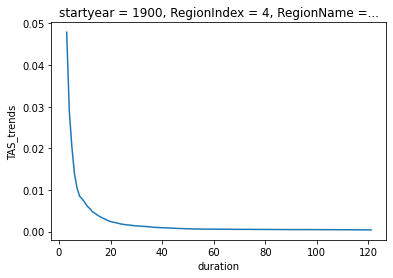

In [18]:
gistemp_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [19]:
del gistemp_5x5_ds,gistemp_annual,gistemp_trends_all

#### HadCRUT5

In [24]:
%%time
hadcrut5_filelist = []
for _file in hadcrut5_files:
    # print(_file)
    _hadcrut5_ds = xr.open_dataset(_file)
    _hadcrut5_annual = _hadcrut5_ds[hadcrut5_tas_var].groupby('time.year').mean('time')

    hadcrut5_filelist.append(_hadcrut5_annual)

hadcrut5_annual = xr.concat(hadcrut5_filelist, dim="realization")

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/

CPU times: user 13.6 s, sys: 181 ms, total: 13.8 s
Wall time: 20.7 s


In [28]:
%%time

hadcrut5_trends_all = compute_trends_wrapper(hadcrut5_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 7s, sys: 1.09 s, total: 1min 8s
Wall time: 1min 13s


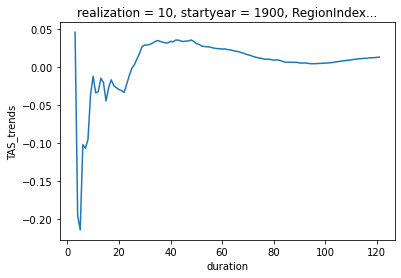

In [29]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0, realization=10).plot()

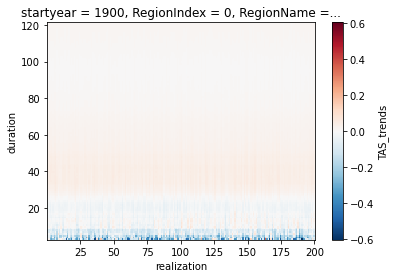

In [30]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0,).sortby("realization").plot()

#### Interesting behavior in the observational uncertainty curve in Central North America when starting the record at 1900.

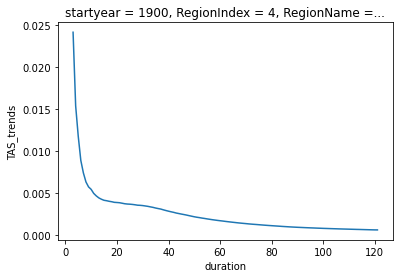

In [31]:
hadcrut5_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [32]:
hadcrut5_trends_all.to_netcdf('%s/%s/HadCRUT.5.0.2.0_1_200.trends.190001-202212.nc' % (obslens_tseries_dir,'HadCRUT5/20240820/'))

In [33]:
del hadcrut5_annual,hadcrut5_trends_all